In [1]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.6.9
Tensorflow version: 2.2.0
Keras version: 2.3.0-tf


Download the dataset

In [3]:
cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)

print(dataset_file_path)

1122304/1115394 [==============================] - 0s 0us/step
/tmp/.keras/datasets/shakespeare.txt


Analyze the dataset

In [4]:
# Reading the database file.
text = open(dataset_file_path, mode='r').read()

print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [5]:
# Take a look at the first 250 characters in text.
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [6]:
# The unique characters in the file
vocab = sorted(set(text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

65 unique characters
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Process the dataset---
Vectorize the text
Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [7]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [9]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [10]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in text])

print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

text_as_int length: 1115394
'First Citizen:\n' --> array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0])


Create training sequences

In [11]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 11043


In [12]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
    print(index2char[char.numpy()])

F
i
r
s
t


In [14]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print('Sequences count: {}'.format(len(list(sequences.as_numpy_iterator()))));
print()

# Sequences examples.
for item in sequences.take(5):
    print(repr(''.join(index2char[item.numpy()])))

Sequences count: 11043

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For each sequence, duplicate and shift it to form the input and target text. For example, say sequence_length is 4 and our text is Hello. The input sequence would be Hell, and the target sequence ello.

In [15]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [16]:
dataset = sequences.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

dataset size: 11043


In [17]:
for input_example, target_example in dataset.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:', repr(''.join(index2char[input_example.numpy()])))
    print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 100
Target sequence size: 100

Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [18]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))

Step  0
  input: 18 ('F')
  expected output: 47 ('i')
Step  1
  input: 47 ('i')
  expected output: 56 ('r')
Step  2
  input: 56 ('r')
  expected output: 57 ('s')
Step  3
  input: 57 ('s')
  expected output: 58 ('t')
Step  4
  input: 58 ('t')
  expected output: 1 (' ')


Split training sequences into batches
We used tf.data to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [19]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [20]:
print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 172


In [21]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[53 59 52 ... 52 58 50]
 [ 1 58 63 ... 42 53 52]
 [ 1 39  1 ... 57 53 50]
 ...
 [43  1 57 ...  1 50 39]
 [56 41 46 ... 46 43  1]
 [53  1 39 ...  1 58 53]], shape=(64, 100), dtype=int64)

1st batch: target_text: tf.Tensor(
[[59 52 42 ... 58 50 43]
 [58 63 56 ... 53 52  1]
 [39  1 54 ... 53 50 59]
 ...
 [ 1 57 47 ... 50 39 51]
 [41 46  1 ... 43  1 40]
 [ 1 39  1 ... 58 53  1]], shape=(64, 100), dtype=int64)


Build the model
Use tf.keras.Sequential to define the model. For this simple example three layers are used to define our model:

tf.keras.layers.Embedding: The input layer. A trainable lookup table that will map the numbers of each character to a vector with embedding_dim dimensions;
tf.keras.layers.LSTM: A type of RNN with size units=rnn_units (You can also use a GRU layer here.)
tf.keras.layers.Dense: The output layer, with vocab_size outputs.

In [22]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[5 6 4 2 4 7 8 5]
 [8 8 6 4 2 1 8 0]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.01283805 -0.04943254  0.02574417 -0.02327505 -0.01583002]
  [-0.00676415  0.0462482   0.02446571 -0.03798606  0.04559894]
  [ 0.01807721  0.03179767  0.01470784 -0.03351275  0.0318118 ]
  [-0.03911901 -0.01544913  0.04707838  0.03865189  0.00768809]
  [ 0.01807721  0.03179767  0.01470784 -0.03351275  0.0318118 ]
  [-0.00266435  0.00316028 -0.0138932   0.04013342 -0.00900233]
  [-0.04909462 -0.02572468  0.00489109  0.0310553   0.02181942]
  [ 0.01283805 -0.04943254  0.02574417 -0.02327505 -0.01583002]]

 [[-0.04909462 -0.02572468  0.00489109  0.0310553   0.02181942]
  [-0.04909462 -0.02572468  0.00489109  0.0310553   0.02181942]
  [-0.00676415  0.0462482   0.02446571 -0.03798606  0.04559894]
  [ 0.01807721  0.03179767  0.01470784 -0.03351275  0.0318118 ]
  [-0.03911901 -0.01544913  0.04707838  0.03865189  0.00768809]
  [-0.00983962 -0.03481568 

In [23]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [24]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model

In [25]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           16640     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


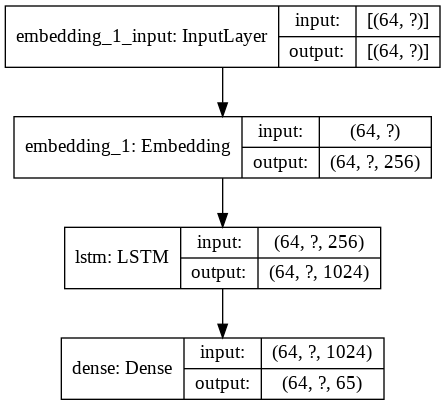

In [27]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

Try the model

In [28]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 65) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [29]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[ 0.00217452 -0.00310985  0.00661094 -0.00478581 -0.00044937 -0.00144599
  0.0064938   0.00361238 -0.00220897  0.00386962  0.0007634   0.00061258
  0.00025081  0.00046291 -0.00125895 -0.00319838 -0.00536989 -0.00711295
 -0.00158446  0.00148223 -0.0077138   0.00277157  0.00144291  0.0011172
  0.0013781   0.0059966  -0.00217291  0.00323616 -0.00659874  0.00208185
 -0.00042071 -0.00072833  0.0062802  -0.00082873 -0.00075093  0.00448762
  0.00368958  0.00119565 -0.00504404 -0.00533272  0.00117605 -0.00252115
 -0.00061579 -0.00036399 -0.00028533 -0.00365689  0.00106547  0.00460416
  0.00531025 -0.00161927  0.00031362  0.00242485  0.00106432  0.0029447
  0.00355659 -0.00453993 -0.00059019  0.00227674 -0.00064165  0.00495461
  0.00395488 -0.0024426  -0.00236988 -0.00088797  0.0005678 ], shape=(65,), dtype=float32)


In [30]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities 
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 2 0 2 1]], shape=(1, 5), dtype=int64)


In [31]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [32]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [33]:
sampled_indices

array([57, 50, 55, 33, 15, 17, 62, 42, 16, 16, 44, 48, 18,  3,  5, 56, 46,
       12, 19,  1, 55, 17, 22,  7, 61,  4, 46, 29, 32,  5, 64, 57, 51, 63,
       62, 24,  6, 59, 46, 21, 60, 51, 14, 19,  3, 58, 30, 43,  3, 61, 15,
       63, 46, 35, 25,  6, 49, 23, 31, 42, 38, 25, 57, 59, 53, 43, 35, 25,
       51, 34, 57,  0, 20,  3,  3, 21, 13, 38, 26, 59, 30, 54, 54, 64, 17,
       28, 40, 41, 44, 33, 18, 46,  1, 43, 47, 15, 21, 34, 21, 45])

In [34]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 "s part\nPerform'd in this wide gap of time since first\nWe were dissever'd: hastily lead away.\n\nDUKE V"

Next char prediction:
 "slqUCExdDDfjF$'rh?G qEJ-w&hQT'zsmyxL,uhIvmBG$tRe$wCyhWM,kKSdZMsuoeWMmVs\nH$$IAZNuRppzEPbcfUFh eiCIVIg"


In [35]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))

Prediction  0
  input: 57 ('s')
  next predicted: 1 ('s')
Prediction  1
  input: 1 (' ')
  next predicted: 1 ('l')
Prediction  2
  input: 54 ('p')
  next predicted: 1 ('q')
Prediction  3
  input: 39 ('a')
  next predicted: 1 ('U')
Prediction  4
  input: 56 ('r')
  next predicted: 1 ('C')


Train the model
At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

Attach an optimizer, and a loss function

In [36]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.1736574


In [37]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

Configure checkpoints

In [38]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

Execute the training

In [41]:
EPOCHS=30

In [42]:
history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/30
172/172 [==============================] - 1137s 7s/step - loss: 2.6030
Epoch 2/30
172/172 [==============================] - 1139s 7s/step - loss: 1.8850
Epoch 3/30
172/172 [==============================] - 1132s 7s/step - loss: 1.6380
Epoch 4/30
172/172 [==============================] - 1127s 7s/step - loss: 1.5067
Epoch 5/30
172/172 [==============================] - 1136s 7s/step - loss: 1.4279
Epoch 6/30
172/172 [==============================] - 1130s 7s/step - loss: 1.3711
Epoch 7/30
172/172 [==============================] - 1125s 7s/step - loss: 1.3276
Epoch 8/30
172/172 [==============================] - 1123s 7s/step - loss: 1.2901
Epoch 9/30
172/172 [==============================] - 1128s 7s/step - loss: 1.2556
Epoch 10/30
172/172 [==============================] - 1128s 7s/step - loss: 1.2211
Epoch 11/30
172/172 [==============================] - 1129s 7s/step - loss: 1.1883
Epoch 12/30
172/172 [==============================] - 1137s 7s/step - loss: 1.1540
E

In [43]:
def get_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

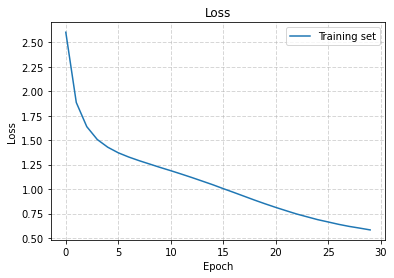

In [44]:
get_training_history(history)

In [45]:
model_name = 'text_gen_using_rnn.h5'
model.save(model_name, save_format='h5')